# Часть 1. Проверка гипотезы в Python и составление аналитической записки

Мы предобработали данные в SQL, и теперь они готовы для проверки гипотезы в Python. Загрузим данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности из файла.

Проверим наличие дубликатов в идентификаторах пользователей. Сравним размеры групп, их статистики и распределение.

Наша гипотеза выглядит следующим образом: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуем статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

По результатам анализа данных подготовим аналитическую записку, в которой опишем:

Выбранный тип t-теста и уровень статистической значимости.

Результат теста.

Вывод на основе полученного p-value, то есть интерпретацию результатов.

Причины, объясняющие полученные результаты.

## Цели и задачи проекта

Цель проекта: изучение и сравнение активности пользователей из Москвы и Санкт-Петербурга

Задачи:
- загрузка данных и знакомство с ними
- проверка гипотезы
- составление аналитической записки

## Описание данных
Мы будем работать с таблицей, которая содержит следующие поля:
- `city` — город пользователя;
- `puid` — идентификатор пользователя;
- `hours` — общее количество часов активности.

## Содержимое проекта

1. Загрузка данных и знакомство с ними
2. Проверка гипотезы в Python
3. Аналитическая записка

---

## 1. Загрузка данных и знакомство с ними

Загрузим данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла.

In [1]:
# импортируем библиотеку pandas
import pandas as pd
# импортируем библиотеку matplotlib.pyplot для построения графика
import matplotlib.pyplot as plt

import seaborn as sns

import scipy.stats as st

from statsmodels.stats.power import NormalIndPower
import statsmodels.stats.api as sms

from statsmodels.stats.proportion import proportions_ztest

In [2]:
# сохраняем датафрейм в переменную
df = pd.read_csv('', index_col='Unnamed: 0')

In [3]:
# выводим на экран 5 первых строк датафрейма
df.head()

,city,puid,hours
0,Москва,9668,26.167776
1,Москва,16598,82.111217
2,Москва,80401,4.656906
3,Москва,140205,1.840556
4,Москва,248755,151.326434


Проверим столбец `puid` на наличие дубликатов

In [4]:
dupl = df.duplicated(subset='puid').sum()
display(f'Количество дубликатов в идентификаторах пользователей {dupl}')

'Количество дубликатов в идентификаторах пользователей 244'

Для проверки гипотезы наши данные должны быть независимыми. Поэтому дублирующиеся идентификаторы пользователей следует удалить из выборки.

In [5]:
df_clear = df.drop_duplicates(subset='puid')

Для нашего теста мы рассматриваем пользователей из двух городов: Москвы и Санкт-Петербурга. Это и есть две наши группы. Сравним размеры изучаемых групп. 

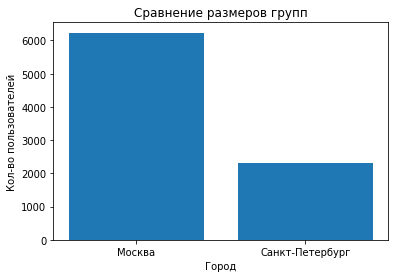

In [6]:
#группируем данные по городам, считая кол-во пользователей в каждом городе
df_group = df_clear.groupby('city')['puid'].count().reset_index()

# строим столбчатую диаграмму
plt.bar(df_group['city'], df_group['puid'])

# подписываем ось X
plt.xlabel("Город")

# подписываем ось Y
plt.ylabel("Кол-во пользователей")

# задаём заголовок графика
plt.title("Сравнение размеров групп")

# показываем график
plt.show()

По построенной диаграмме видим, что в Москве почти в 3 раза больше пользователей, чем в Санкт-Петербурге.

Найдем статистики для каждой из групп.

Длительность прослушиваний является важной метрикой в работе сервиса Яндекс Книги. Если средняя длительность прослушиваний будет слишком высокой, это может говорить о наличии технических проблем. Например, зацикливание воспроизведения: может быть ошибка в приложении или на сервере, из-за которой аудиокнига зацикливается и проигрывается повторно, даже когда пользователь не слушает. Если средняя длительность прослушиваний будет слишком низкой, это может означать, что пользователям что-то не нравится в сервисе.

С помощью описательной статистики изучим длительность прослушиваний.

In [10]:
duration_mean_MSK = int(round(df_clear[df_clear['city']=='Москва']['hours'].mean(),0))
duration_std_MSK = int(round(df_clear[df_clear['city']=='Москва']['hours'].std(),0))

duration_pct25_MSK = int(round(df_clear[df_clear['city']=='Москва']['hours'].quantile(0.25),0))
duration_pct75_MSK = int(round(df_clear[df_clear['city']=='Москва']['hours'].quantile(0.75),0))

print(f'Средняя длительность прослушивания в Москве {duration_mean_MSK} часов со стандартным отклонением {duration_std_MSK}.\nОсновная часть прослушиваний занимает от {duration_pct25_MSK} до {duration_pct75_MSK} часов.')

Средняя длительность прослушивания в Москве 11 часов со стандартным отклонением 37.
Основная часть прослушиваний занимает от 0 до 6 часов.


In [11]:
duration_mean_SPB = int(round(df_clear[df_clear['city']=='Санкт-Петербург']['hours'].mean(),0))
duration_std_SPB = int(round(df_clear[df_clear['city']=='Санкт-Петербург']['hours'].std(),0))

duration_pct25_SPB = int(round(df_clear[df_clear['city']=='Санкт-Петербург']['hours'].quantile(0.25),0))
duration_pct75_SPB = int(round(df_clear[df_clear['city']=='Санкт-Петербург']['hours'].quantile(0.75),0))

print(f'Средняя длительность прослушивания в Санкт-Петербурге {duration_mean_SPB} часов со стандартным отклонением {duration_std_SPB}.\nОсновная часть прослушиваний занимает от {duration_pct25_SPB} до {duration_pct75_SPB} часов.')

Средняя длительность прослушивания в Санкт-Петербурге 11 часов со стандартным отклонением 40.
Основная часть прослушиваний занимает от 0 до 6 часов.


**Общие наблюдения для обоих городов:**

-  Схожая средняя длительность: Средняя длительность прослушивания в Москве и Санкт-Петербурге практически идентична (11 часов). Это говорит о том, что в среднем пользователи в обоих городах проводят примерно одинаковое количество времени, слушая аудиокниги в вашем сервисе.
-  Высокое стандартное отклонение: Стандартное отклонение (37 часов для Москвы и 40 часов для Санкт-Петербурга) значительно превышает среднюю длительность (11 часов). Это указывает на очень большую вариативность времени прослушивания среди пользователей. Другими словами, есть пользователи, которые слушают аудиокниги очень долго, а есть те, кто слушает очень мало.
-  Практически все пользователи прослушивают не более 6 часов: Тот факт, что "основная часть прослушиваний занимает от 0 до 6 часов" в сочетании с высокой средней и высоким стандартным отклонением говорит о том, что распределение времени прослушивания имеет тяжелый правый хвост. Это означает, что небольшое количество пользователей слушают книги очень-очень долго, существенно увеличивая среднюю длительность.

**Сравнение Москвы и Санкт-Петербурга:**

-  Более высокая вариативность в Санкт-Петербурге: Стандартное отклонение в Санкт-Петербурге немного выше, чем в Москве, что говорит о чуть большей разнородности в длительности прослушивания среди пользователей в Санкт-Петербурге.

Построим на графике гистограмму распределения длительности прослушиваний `hours` для пользователей из Москвы и Санкт-Петербурга.

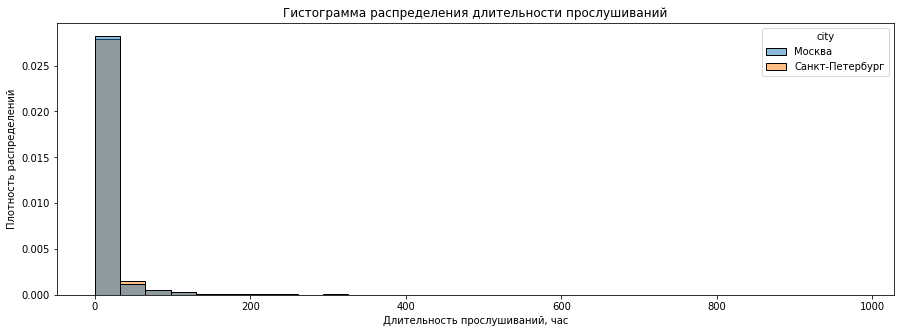

In [12]:
# Гистограмма длительности поездки для пользователей из Москвы и СПБ
plt.figure(figsize=(15, 5))
sns.histplot(data=df_clear,x='hours',bins=30,hue='city',stat='density', common_norm=False)

plt.xlabel('Длительность прослушиваний, час')
plt.ylabel('Плотность распределений')
plt.title('Гистограмма распределения длительности прослушиваний')

plt.show()

Данные имеют практически идентичное распределение с длинным правым хвостом.

## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуем статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах Санкт-Петербурге не больше, чем в Москве.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

Так как наши данные имеют большие хвосты, привычный t-test не подойдёт в нашем случае. Поэтому проведём A/B-тестирование с помощью t-test Уэлча.

In [13]:
alpha:float = 0.05

duration_MSK = df_clear[df_clear['city'] == 'Москва']['hours']
duration_SPB = df_clear[df_clear['city'] == 'Санкт-Петербург']['hours']

In [14]:
stat_welch_ttest, p_value_welch_ttest = st.ttest_ind(
    duration_SPB, 
    duration_MSK, 
    equal_var=False,
    alternative='greater' ## поскольку альтернативная гипотеза о том, что выборочное среднее первой выборки (duration_SPB) больше второй выборки
) ## применяем t-тест Уэлча
if p_value_welch_ttest>alpha:
    print(f'p-value теста Уэлча ={round(p_value_welch_ttest, 2)}')
    print('Нулевая гипотеза находит подтверждение! Выборочные средние в группе В не больше, чем в группе A')
    print('Интерпретация: среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве')
else:
    print(f'p-value теста Уэлча ={round(p_value_welch_ttest, 2)}')
    print('Нулевая гипотеза не находит подтверждения! Выборочные средние в группах A и B не равны, и в группе B больше')
    print('Интерпретация: среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо')

display(f'Средняя длительность прослушиваний в Москве {duration_mean_MSK} часов')
display(f'Средняя длительность прослушиваний в Санкт-Петербурге {duration_mean_SPB} часов')

p-value теста Уэлча =0.34
Нулевая гипотеза находит подтверждение! Выборочные средние в группе В не больше, чем в группе A
Интерпретация: среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве


'Средняя длительность прослушиваний в Москве 11 часов'

'Средняя длительность прослушиваний в Санкт-Петербурге 11 часов'

## 3. Аналитическая записка

- Так как данные о длительности прослушиваний в обоих городах имели достаточно длинные правые хвосты, мы выбрали t-test Уэлча, так как он нечувствителен к ассиметрии данных. Уровень статистической значимости был выбран равный 0.05.

- В результате проведённого A/B-теста мы не смогли опровергнуть нулевую гипотезу о том, что средняя активность пользователей Санкт-Петербурге не больше, чем в Москве.

- p-value в результате теста получился равен примерно **0.34**, что значительно больше выбранного уровня значимости alpha (0.05). Таким образом, мы принимаем нулевую гипотезу. Это говорит о том, что средняя активность пользователей в часах Санкт-Петербурге не больше, чем в Москве.

- Самая простая причина, объясняющая результат проведённого тестирования - в реальности нет существенной разницы в средней активности пользователей между Москвой и Санкт-Петербургом. Любая наблюдаемая разница обусловлена случайностью.

----

# Часть 2. Анализ результатов A/B-тестирования

## 1. Цель и задачи исследования.



Цель исследования: проверка корректности проведения A/B-тестирования и анализ его результатов.

Задачи исследования:
- Загрузка данных и их оценка
- Оценка корректности проведения теста
- Оценка результатов A/B-теста

## 2. Загрузка и оценка данных.


In [15]:
participants = pd.read_csv('')
events = pd.read_csv('',
                     parse_dates=['event_dt'], low_memory=False)

Выведем основную информацию о датафрейме `participants` и проверим его на пропуски.

In [16]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


Таблица не содержит пропусков, все данные заполнены. Таблица состоит из 4 столбцов и 14 525 строк.

Выведем основную информацию о таблице `events` и также проверим данные на наличие пропусков.

In [17]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


Таблица `events` состоит из 4 столбцов и 787 286 строк. Пропуски содержатся в столбце `details` (дополнительные данные о событии), но так как данные этого столбца для исследования нам не пригодятся, оставим их без внимания.

Проверим таблицу `events` на полные дубликаты.

In [18]:
display(events.duplicated().sum())

36318

Мы нашли 36 318 тысяч строк полных дубликатов. Избавимся от них.

In [19]:
events_clear = events.drop_duplicates()

## 3. Оценка корректности проведенного теста.

Оставим в таблице `participants` данные только о тесте `interface_eu_test`.

In [20]:
ab_test_participants = participants[participants['ab_test']=='interface_eu_test']

Проверим наши данные на пересечение пользователей. Проверять будем по столбцу `user_id`.

In [21]:
A = ab_test_participants[ab_test_participants['group'] == 'A']['user_id']
B = ab_test_participants[ab_test_participants['group'] == 'B']['user_id']

intersection = list(set(A) & set(B))
display(len(intersection)) 

0

Контрольная и тестовая группа не имеют пересечений, что является одним из признаков корректного проведения теста.

Теперь посмотрим на распределение пользователей по группам. Для этого построим круговую диаграмму

In [22]:
unique_users = ab_test_participants.groupby('group')['user_id'].nunique().reset_index()

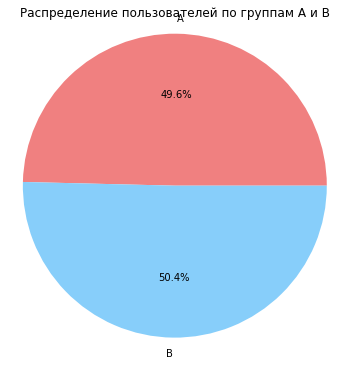

In [23]:
group_A = 100 * unique_users[unique_users['group'] == 'A']['user_id'].sum() / unique_users['user_id'].sum()
group_B = 100 * unique_users[unique_users['group'] == 'B']['user_id'].sum() / unique_users['user_id'].sum()

sizes = [group_A, group_B]
labels = ['A', 'B']
colors = ['lightcoral', 'lightskyblue'] #Необязательно, можно выбрать любые цвета

# Строим круговую диаграмму
plt.figure(figsize=(6, 6))  # Задаем размер диаграммы (необязательно)
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
autopct='%1.1f%%' #форматирует отображение процентов (один знак после запятой)
# startangle=140 - поворачивает диаграмму, чтобы первый сектор начинался под углом 140 градусов (необязательно)

plt.title('Распределение пользователей по группам A и B')
plt.axis('equal')  #  Обеспечивает, чтобы круговая диаграмма выглядела как круг, а не как эллипс.
plt.show()

По круговой диаграмме наглядно видно, что пользователи между группами распределены равномерно.

Так как таблица `participants` содержит данные не только о тесте `interface_eu_test`, выведем на экран уникальные значения из столбца `ab_test` и проверим пересечение тестовой группы нашего исследования с тестовыми группами других исследований.

In [24]:
participants['ab_test'].unique()

array(['interface_eu_test', 'recommender_system_test'], dtype=object)

In [25]:
B_rec = participants[(participants['group'] == 'B')&(participants['ab_test']=='recommender_system_test')]['user_id']

intersection = list(set(B) & set(B_rec))
display(len(intersection)) 

116

Тестовая группа нашего исследования имеет 116 пересечений с тестовой группой конкурирующего теста. Для корректности проведения исследования избавимся от этих пересечений, удалив этих пользователей из тестовой группы нашего A/B-теста.

In [26]:
ab_test_participants = ab_test_participants[~(ab_test_participants['user_id'].isin(intersection))]
B = ab_test_participants[ab_test_participants['group'] == 'B']['user_id']

Проверим, как изменится распределение пользователей после удаления пересечений:

In [27]:
ab_test_participants[ab_test_participants['group'] == 'A']['user_id'].nunique(), ab_test_participants[ab_test_participants['group'] == 'B']['user_id'].nunique()

(5383, 5351)

Распределение пользователей осталось также равномерным.

In [28]:
ab_test_events = events_clear[events_clear['user_id'].isin(ab_test_participants['user_id'])]

- определим горизонт анализа: рассчитаем время (лайфтайм) совершения события пользователем после регистрации и оставим только те события, которые были выполнены в течение первых семи дней с момента регистрации;

Создадим отдельный датафрейм с id пользователей и датой их регистрации.

In [29]:
registration_dates = ab_test_events[ab_test_events['event_name'] == 'registration'][['user_id', 'event_dt']].rename(columns={'event_dt': 'registration_dt'})

In [30]:
registration_dates['user_id'].duplicated().sum()

0

Добавляем для каждой строки события таблицы ab_test_events дату регистрации пользователя.

In [31]:
ab_test_events = pd.merge(ab_test_events, registration_dates, on='user_id', how='left')

Добавим ещё один столбец, который будет содержать разность между датой события и датой регистрации пользователя.

In [32]:
ab_test_events['lifetime'] = (ab_test_events['event_dt'] - ab_test_events['registration_dt']).dt.days

Фильтруем события, произошедшие в течение 7 дней после регистрации

In [33]:
ab_test_events_filtered = ab_test_events[ab_test_events['lifetime'] < 7]
ab_test_events_filtered.head()

,user_id,event_dt,event_name,details,registration_dt,lifetime
0,5F506CEBEDC05D30,2020-12-06 14:10:01,registration,0.0,2020-12-06 14:10:01,0
1,51278A006E918D97,2020-12-06 14:37:25,registration,-3.8,2020-12-06 14:37:25,0
2,A0C1E8EFAD874D8B,2020-12-06 17:20:22,registration,-3.32,2020-12-06 17:20:22,0
3,275A8D6254ACF530,2020-12-06 19:36:54,registration,-0.48,2020-12-06 19:36:54,0
4,0B704EB2DC7FCA4B,2020-12-06 19:42:20,registration,0.0,2020-12-06 19:42:20,0


Оценим достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%,

- ожидаемый прирост 3 процентных пункта.

In [34]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
power = 0.8  # Мощность теста
mde = 0.3  # Минимальный детектируемый эффект
mde_new = mde + 0.03 # Ожидаемая конверсия
effect_size = sms.proportion_effectsize(mde, mde_new)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1#,
    #alternative='larger'
)

display(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

if int(sample_size) < ab_test_participants[ab_test_participants['group'] == 'A']['user_id'].nunique():
    display('Выборки имеют достаточные размеры')
else:
    display('Размеры выборок недостаточны')

'Необходимый размер выборки для каждой группы: 3761'

'Выборки имеют достаточные размеры'

Найдём количество посетителей, совершивших покупку для каждой группы.

In [35]:
ab_test = pd.merge(ab_test_participants,ab_test_events_filtered, on='user_id', how='left')
ab_test_purchase = ab_test[ab_test['event_name']=='purchase'].groupby('group')['user_id'].nunique().reset_index().rename(columns={'user_id': 'count_buyer'})
display(ab_test_purchase)

,group,count_buyer
0,A,1480
1,B,1579


Найдём общее количество посетителей для каждой группы.

In [36]:
ab_test_users = ab_test.groupby('group')['user_id'].nunique().reset_index().rename(columns={'user_id': 'count_users'})
display(ab_test_users)

,group,count_users
0,A,5383
1,B,5351


Соединим данные групп о количестве покупателей с общим количеством пользователей.

In [37]:
ab_test = pd.merge(ab_test_purchase,ab_test_users,on='group')
display(ab_test)

,group,count_buyer,count_users
0,A,1480,5383
1,B,1579,5351


Для формирования предварительного вывода найдём доли пользователей, совершивших покупку, относительно общего количества пользователей для каждой из групп.

In [38]:
ab_test['share_buyer'] = ab_test['count_buyer']/ab_test['count_users']
display(ab_test)

,group,count_buyer,count_users,share_buyer
0,A,1480,5383,0.274940
1,B,1579,5351,0.295085


По предварительному анализу мы видим что доля пользователей совершивших покупку в группе B примерно на 2 п.п. больше, чем в группе A. Предполагаем, что тестовая группа показывает положительную динамику, однако нам необходим прирост в 3 п.п.. Таким образом фактический прирост недостаточно высок.

## 4. Оценка результатов A/B-тестирования:

Напомним, что для нашего теста существуют две гипотезы:

Нулевая гипотеза $H_0: \mu_{\text{B}} \leq \mu_{\text{A}}$ <br> Изменение интерфейса сайта не увеличит количество пользователей, совершающих покупку.

Альтернативная гипотеза $H_1: \mu_{\text{B}} > \mu_{\text{A}}$ <br> Изменение интерфейса сайта увеличит количество пользователей, совершающих покупку, и это различие статистически значимо.

В качестве статистического теста выберем Z-тест пропорций, так как в нашем случае мы сравниваем доли.

In [39]:
# Задаём размеры выборок
n_a, n_b = ab_test[ab_test['group']=='A']['count_users'].sum(), ab_test[ab_test['group']=='B']['count_users'].sum()
# Задаём количество успехов в каждой выборке
m_a, m_b = ab_test[ab_test['group']=='A']['count_buyer'].sum(), ab_test[ab_test['group']=='B']['count_buyer'].sum()

In [40]:
alpha = 0.05 ## на каком уровне значимости проверяем гипотезу о равенстве вероятностей

stat_ztest, p_value_ztest = proportions_ztest(
    [m_b, m_a],
    [n_b, n_a],
    alternative='larger' # так как H_1: p_a < p_b
)
p_value_ztest

0.010393282955333764

In [41]:
if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

pvalue=0.010393282955333764 < 0.05
Нулевая гипотеза не находит подтверждения!


In [42]:
display(ab_test[ab_test['group']=='B']['share_buyer'].sum()-ab_test[ab_test['group']=='A']['share_buyer'].sum())

0.02014540609079163

По всем проведённым выше проверкам мы получили следующий результат:

- Статистический Z-тест пропорций показал нам, что значение p_value = 0.01, что меньше установленного уровня значимости alpha=0.05. Это даёт нам основание утверждать, что нулевая гипотеза не находит подтверждения.
- Также необходимо было проверить, что конверсия зарегистрированных пользователей в покупателей увеличится как минимум на три процентных пункта. Мы нашли разницу между конверсиями групп A и B, и она составила 2 п.п., что недостаточно для запланированного эффекта изменений.

Таким образом, мы можем утверждать, что изменение интерфейса сайта доказуемо повысит количество пользователей, которые совершат покупку, но менее, чем на 3 п.п.